<a href="https://colab.research.google.com/github/yasarsultan/AIML/blob/main/AIML_Project_Module_5_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression analysis on a COVID-dataset


In this project, we will use the concepts of regression and regularization we have learnt to predict early Covid-19 cases. We shall use linear regression, polynomial regression and ridge regression to obtain a reasonably good estimate of the future cases. Try experimenting with hyperparameters to obtain better results.

## Data Analysis

### 1. **Load the data** into a pandas dataframe.

In [1]:
# Imports
import pandas as pd
import numpy  as np
import scipy.integrate

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import copy
from   sklearn.metrics       import mean_squared_error, mean_absolute_error
from   sklearn.linear_model  import LinearRegression, BayesianRidge
from   sklearn.tree          import DecisionTreeRegressor
from   sklearn.preprocessing import PolynomialFeatures

In [2]:
path = "https://raw.githubusercontent.com/PranavTadimeti/Regression_Project/main/covid_19_data.csv"
df_orig = pd.read_csv(path)
print(df_orig)

         SNo ObservationDate Province/State  Country/Region  \
0          1      01/22/2020          Anhui  Mainland China   
1          2      01/22/2020        Beijing  Mainland China   
2          3      01/22/2020      Chongqing  Mainland China   
3          4      01/22/2020         Fujian  Mainland China   
4          5      01/22/2020          Gansu  Mainland China   
...      ...             ...            ...             ...   
10666  10667      03/31/2020        Wyoming              US   
10667  10668      03/31/2020       Xinjiang  Mainland China   
10668  10669      03/31/2020          Yukon          Canada   
10669  10670      03/31/2020         Yunnan  Mainland China   
10670  10671      03/31/2020       Zhejiang  Mainland China   

               Last Update  Confirmed  Deaths  Recovered  
0          1/22/2020 17:00        1.0     0.0        0.0  
1          1/22/2020 17:00       14.0     0.0        0.0  
2          1/22/2020 17:00        6.0     0.0        0.0  
3      


### 2. Create a new dataframe which counts the cumulative total number of cases, the cumulative total number of deaths, and also  cumulative total number of recoveries for each date.

In [5]:
df = copy.deepcopy(df_orig)
df.drop('Last Update', inplace=True, axis=1)
date_lst = df.ObservationDate.unique()
date_dict = {}

for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]]
    date_dict[date_lst[i]] = df_temp

In [6]:
date_tot_tup_dict = {};
for date, df in date_dict.items():
    tup_temp = (df['Confirmed'].sum(), df['Deaths'].sum(), df['Recovered'].sum())
    date_tot_tup_dict[date] = tup_temp

In [7]:
print(date_tot_tup_dict)

{'01/22/2020': (555.0, 17.0, 28.0), '01/23/2020': (653.0, 18.0, 30.0), '01/24/2020': (941.0, 26.0, 36.0), '01/25/2020': (1438.0, 42.0, 39.0), '01/26/2020': (2118.0, 56.0, 52.0), '01/27/2020': (2927.0, 82.0, 61.0), '01/28/2020': (5578.0, 131.0, 107.0), '01/29/2020': (6165.0, 133.0, 126.0), '01/30/2020': (8235.0, 171.0, 143.0), '01/31/2020': (9925.0, 213.0, 222.0), '02/01/2020': (12038.0, 259.0, 284.0), '02/02/2020': (16787.0, 362.0, 472.0), '02/03/2020': (19881.0, 426.0, 623.0), '02/04/2020': (23892.0, 492.0, 852.0), '02/05/2020': (27636.0, 564.0, 1124.0), '02/06/2020': (30818.0, 634.0, 1487.0), '02/07/2020': (34392.0, 719.0, 2011.0), '02/08/2020': (37121.0, 806.0, 2616.0), '02/09/2020': (40151.0, 906.0, 3244.0), '02/10/2020': (42763.0, 1013.0, 3946.0), '02/11/2020': (44803.0, 1113.0, 4683.0), '02/12/2020': (45222.0, 1118.0, 5150.0), '02/13/2020': (60370.0, 1371.0, 6295.0), '02/14/2020': (66887.0, 1523.0, 8058.0), '02/15/2020': (69032.0, 1666.0, 9395.0), '02/16/2020': (71226.0, 1770.0, 

In [11]:
df_date_tots = pd.DataFrame(date_tot_tup_dict)
df_date_tots = df_date_tots.transpose()
df_date_tots.columns = ['Confirmed', 'Deaths', 'Recovered']
print(df_date_tots.head())

            Confirmed  Deaths  Recovered
01/22/2020      555.0    17.0       28.0
01/23/2020      653.0    18.0       30.0
01/24/2020      941.0    26.0       36.0
01/25/2020     1438.0    42.0       39.0
01/26/2020     2118.0    56.0       52.0


### 3. Create a new column in the dataframe called **“closed cases”**

In [13]:
df_date_tots['Closed Cases'] = df_date_tots['Deaths'] + df_date_tots['Recovered']
df_date_tots.head()

,Confirmed,Deaths,Recovered,Closed Cases
01/22/2020,555.0,17.0,28.0,45.0
01/23/2020,653.0,18.0,30.0,48.0
01/24/2020,941.0,26.0,36.0,62.0
01/25/2020,1438.0,42.0,39.0,81.0
01/26/2020,2118.0,56.0,52.0,108.0


### 4. Create a new column in the dataframe called “active cases”

In [14]:
df_date_tots['Active Cases'] = df_date_tots['Confirmed'] - df_date_tots['Closed Cases']
df_date_tots.head()

,Confirmed,Deaths,Recovered,Closed Cases,Active Cases
01/22/2020,555.0,17.0,28.0,45.0,510.0
01/23/2020,653.0,18.0,30.0,48.0,605.0
01/24/2020,941.0,26.0,36.0,62.0,879.0
01/25/2020,1438.0,42.0,39.0,81.0,1357.0
01/26/2020,2118.0,56.0,52.0,108.0,2010.0


### 5. **Plot** the total number of cases per day over time and summarize findings

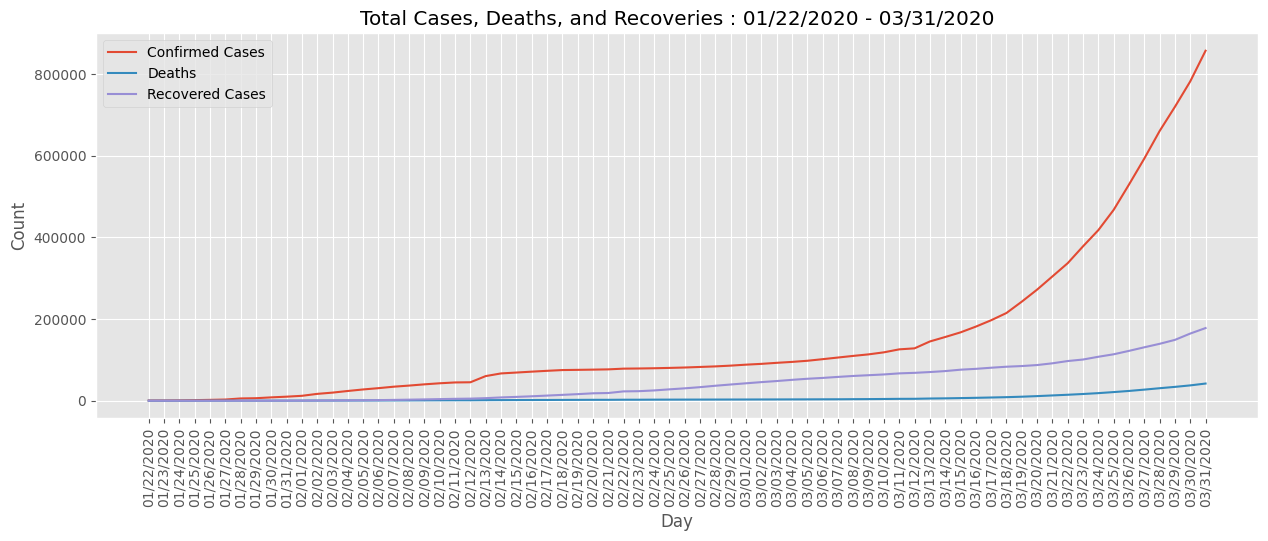

In [16]:
plt.figure(figsize = [15, 5])
plt.plot(df_date_tots['Confirmed'], label = 'Confirmed Cases')
plt.plot(df_date_tots['Deaths'], label = 'Deaths')
plt.plot(df_date_tots['Recovered'], label = "Recovered Cases")

plt.legend()
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date = str(date_lst[len(date_lst) - 1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);

All of the three curves seem to be exponential (start of logistic curve). The confirmed cases was obviously higher than the deaths and recovered cases. The rate of the the recovered cases seems to be higher than that of the death curve.

### 6. Create one **plot** showing the trend of number of active cases and closed cases

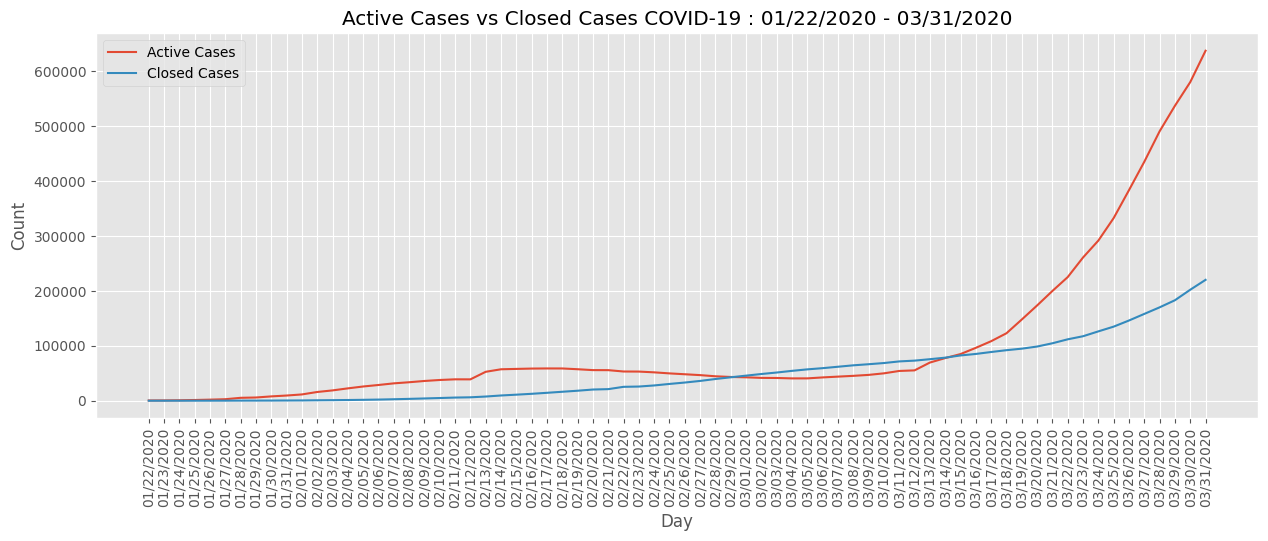

In [17]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Active Cases'], label = "Active Cases")
plt.plot(df_date_tots['Closed Cases'], label = "Closed Cases")

plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Active Cases vs Closed Cases COVID-19 : " + start_date + " - " + fin_date);

The number of active cases is higher than the number of closed cases as of yet.

### 7. Growth Factor

**Growth factor** is the factor by which a quantity multiplies itself over time. In the below cell, we calculate the GF of the confirmed, recovered and death cases.


In [18]:
growth_len_lst = len(date_lst) - 1
confirmed_lst = df_date_tots["Confirmed"]
death_lst = df_date_tots["Deaths"]
recovered_lst = df_date_tots["Recovered"]
confGF_lst = []
deathsGF_lst = []
recovGF_lst = []
for i in range(growth_len_lst):
    confirmedGF = confirmed_lst[i+1] / confirmed_lst[i]
    confGF_lst.append(confirmedGF)
    deathGF = death_lst[i+1] / death_lst[i]
    deathsGF_lst.append(deathGF)
    recoveredGF = recovered_lst[i+1] / recovered_lst[i]
    recovGF_lst.append(recoveredGF);


### 8. Create one plot showing the Growth factor of confirmed, recovered and death cases wrt days

Text(0.5, 1.0, 'Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : 01/22/2020 - 03/31/2020')

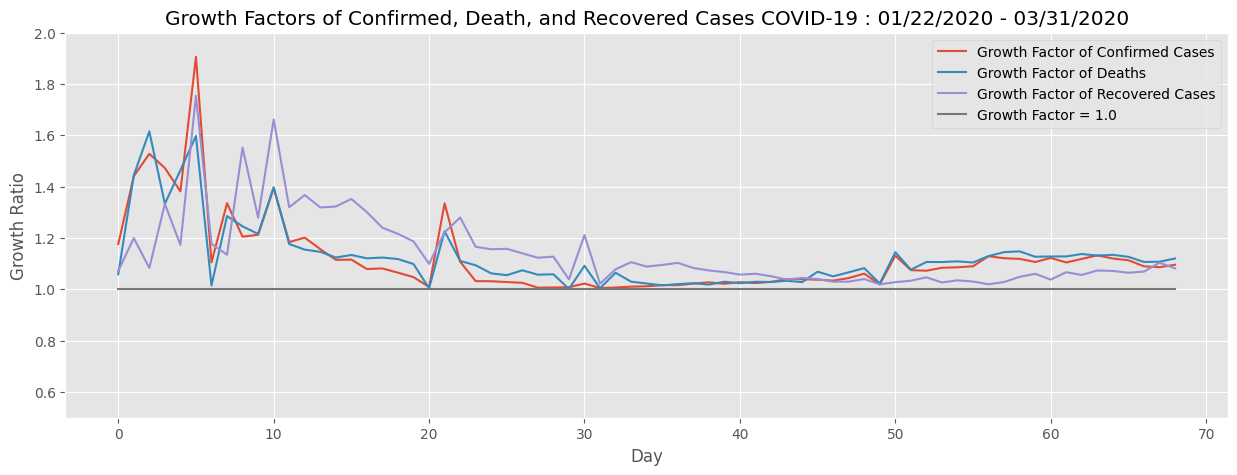

In [24]:
plt.figure(figsize = [15,5])
plt.plot(confGF_lst, label = "Growth Factor of Confirmed Cases")
plt.plot(deathsGF_lst, label = "Growth Factor of Deaths")
plt.plot(recovGF_lst, label = "Growth Factor of Recovered Cases")
x = []
for i in range((growth_len_lst)):
    x.append(1)
plt.plot(x, label = "Growth Factor = 1.0")

#plt.grid()
plt.legend()
plt.xlabel("Day")
plt.ylabel("Growth Ratio")
plt.ylim(.5,2)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : " +start_date +" - " +fin_date)

# **Part 2 - Prediction Using Linear Regression**

#### To make our data to be compatible with *sklearn* format, create a new column called “Days since” which tracks the number of days since the initial date.

In [25]:
days_since_lst = []
for i in range(len(date_lst)):
    days_since_lst.append(i)
df_date_tots["Days Since:"] = days_since_lst
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]]
df_date_tots.head()

,Days Since:,Confirmed,Deaths,Recovered,Active Cases,Closed Cases
01/22/2020,0,555.0,17.0,28.0,510.0,45.0
01/23/2020,1,653.0,18.0,30.0,605.0,48.0
01/24/2020,2,941.0,26.0,36.0,879.0,62.0
01/25/2020,3,1438.0,42.0,39.0,1357.0,81.0
01/26/2020,4,2118.0,56.0,52.0,2010.0,108.0


### 8. Take the earliest 85% of the dates as **train** and the rest as **test**

In [28]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X = np.array(df_date_tots["Days Since:"]).reshape(-1, 1)
y = np.array(df_date_tots["Confirmed"])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False)

### 9. We can try different regression and regularizations we have seen before

#### 9.1 Linear Regression

In [30]:
lin_model = LinearRegression(fit_intercept = False)
lin_model.fit(X_train, y_train)
test_lin_pred = lin_model.predict(X_test)
lin_pred = lin_model.predict(X)

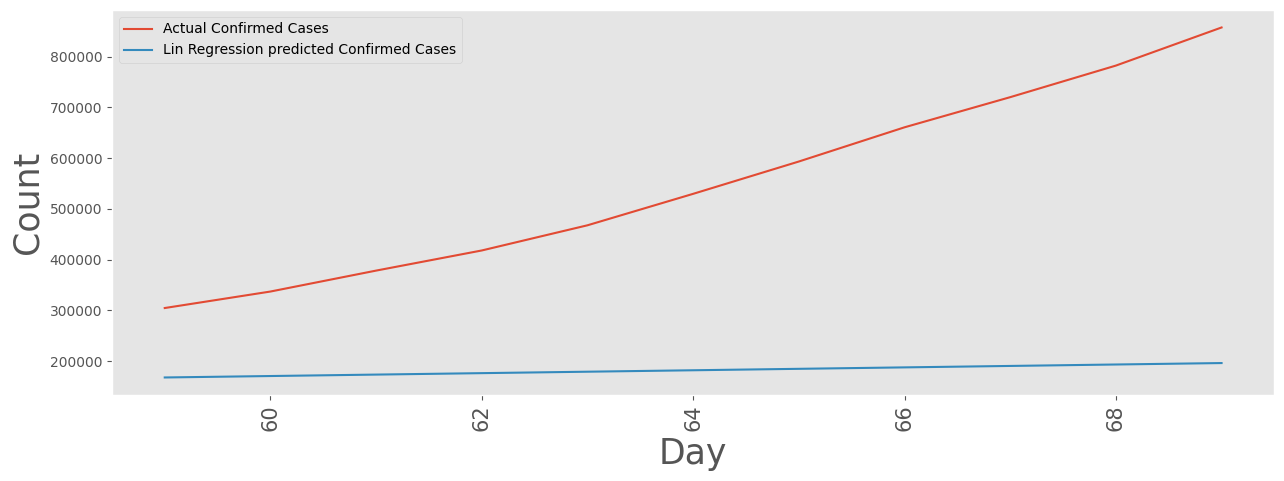

MAE: 181791.423099402
MSE: 33128805402.917187


In [31]:
plt.figure(figsize = [15,5])
# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")
# plotting the predicited values for the future days
plt.plot(X_test,
         test_lin_pred,
         label = "Lin Regression predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, X_test))
print('MSE:', mean_squared_error  (test_lin_pred, X_test))

#### Polynomial Regression

In [33]:
poly = PolynomialFeatures(degree=5)
poly_X_train = poly.fit_transform(X_train)
poly_X_test  = poly.fit_transform(X_test)
poly_X = poly.fit_transform(X)

In [34]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
test_poly_pred = linear_model.predict(poly_X_test)
poly_pred = linear_model.predict(poly_X)


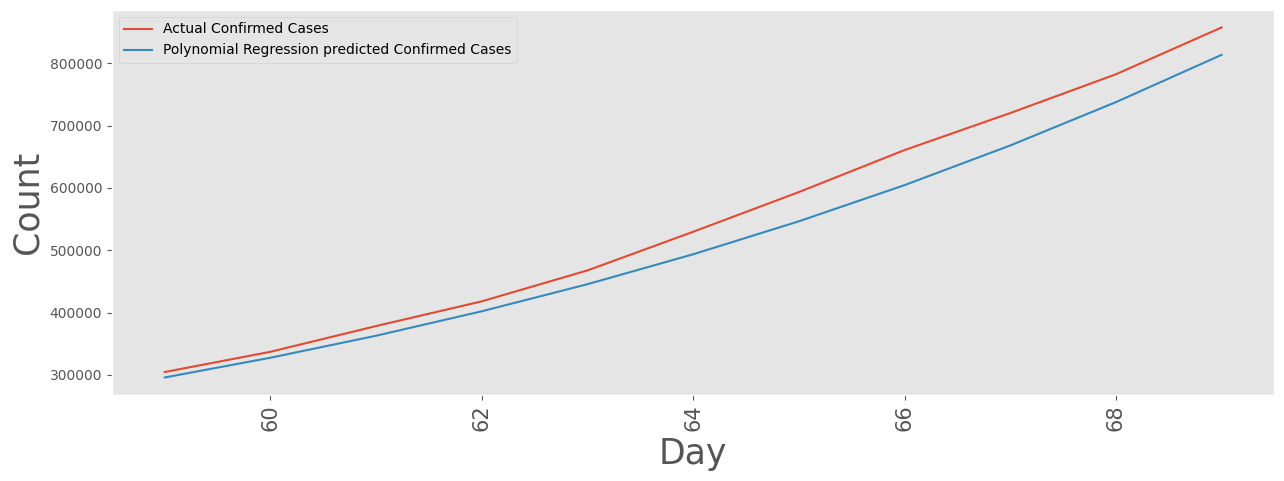

MAE: 31989.752428427022
MSE: 1314905574.5277777


In [36]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_pred,
         label = "Polynomial Regression predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(test_poly_pred, y_test))
print('MSE:',mean_squared_error(test_poly_pred, y_test))

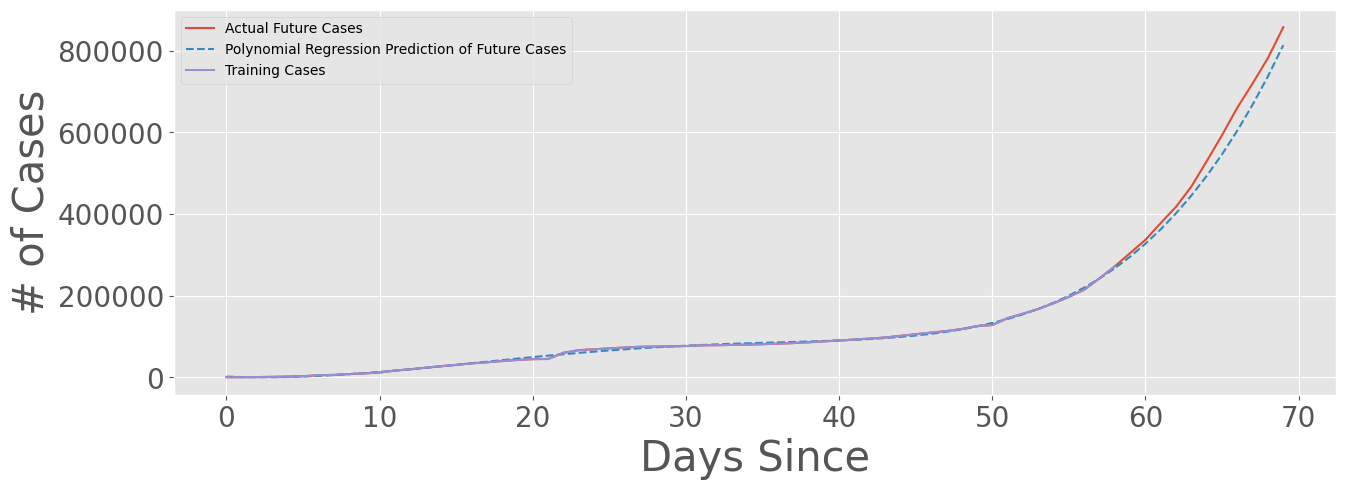

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')

plt.plot(X,
         poly_pred,
         label = 'Polynomial Regression Prediction of Future Cases',
         linestyle = "dashed")

plt.plot(X_train,
         y_train,
         label = 'Training Cases')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 9.2 Ridge Regression

In [38]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(X_train, y_train)

print(bayesian_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.001, 'lambda_2': 1e-07, 'lambda_1': 0.0001, 'alpha_2': 1e-07, 'alpha_1': 1e-07}


In [39]:
y_test_ridge_pred = bayesian_search.predict(X_test);
y_ridge_pred = bayesian_search.predict(X);

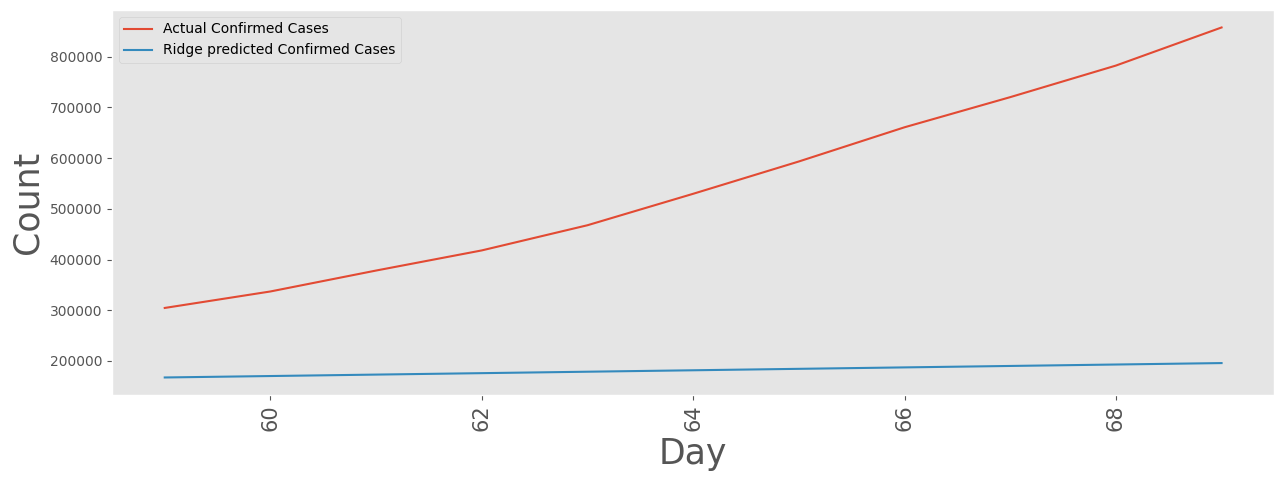

MAE: 181588.76120723973
MSE: 33054982293.94005


In [40]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         y_test_ridge_pred,
         label = "Ridge predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

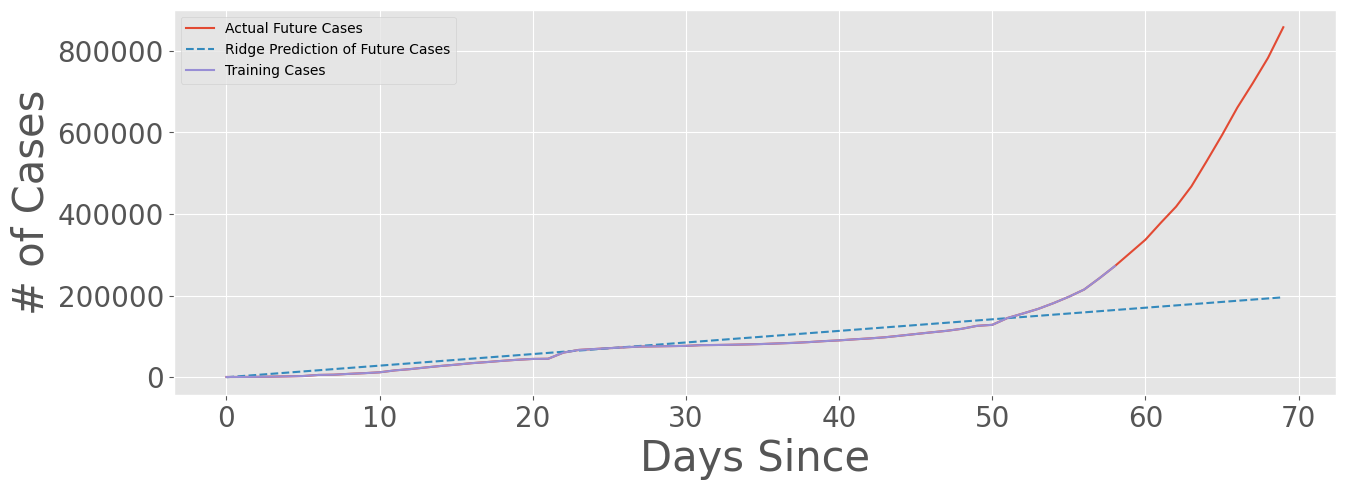

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         y_ridge_pred,
         label = 'Ridge Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

#### Polynomial Ridge Regression

In [42]:
bayesian_search_poly = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)


In [43]:
bayesian_search_poly.fit(poly_X_train, y_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1': 0.0001, 'alpha_2': 1e-07, 'alpha_1': 1e-06}


In [44]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_X_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_X)

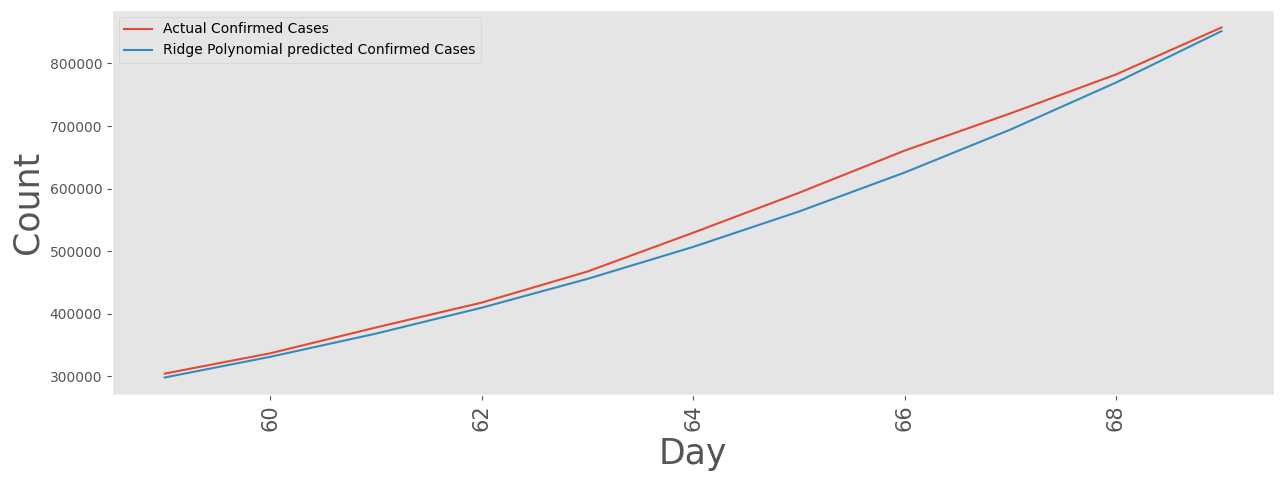

MAE: 15796.104528765141
MSE: 352565821.2177801


In [45]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_bayesian_pred,
         label = "Ridge Polynomial predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('MSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

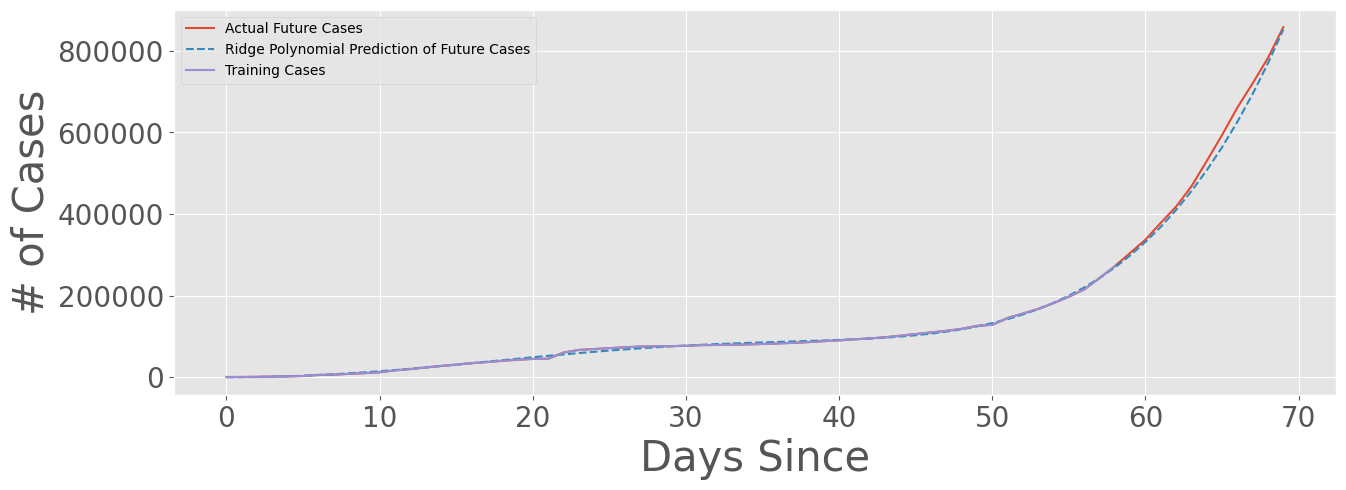

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [47]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_poly_pred, y_test))
print('\tMSE:',mean_squared_error(test_poly_pred, y_test))

print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

Polynomial Regression 
	MAE: 31989.752428427022
	MSE: 1314905574.5277777

Ridge Polynomial Regression 
	MAE: 15796.104528765141
	MSE: 352565821.2177801


From Mean Absolute Error and Mean Squared Error values, Ridge Polynomial Regression Model seems to be the best model.